In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pickle
import random

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler

from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import CSVLogger
!pip install keras_visualizer
from keras_visualizer import visualizer
from tensorflow.keras.regularizers import l2

# Loading

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


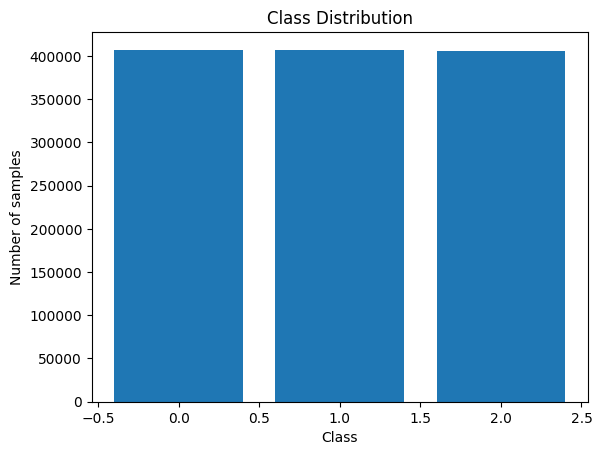

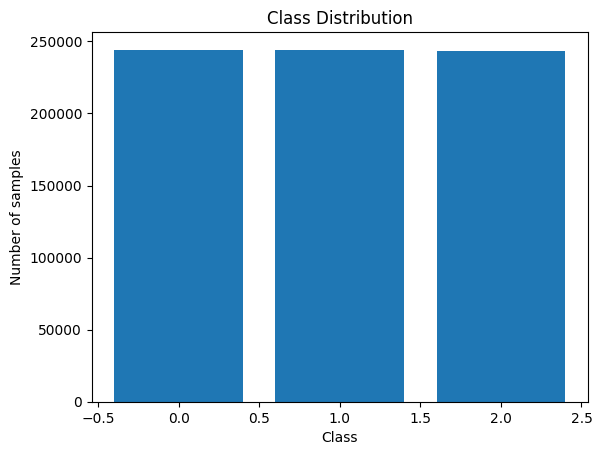

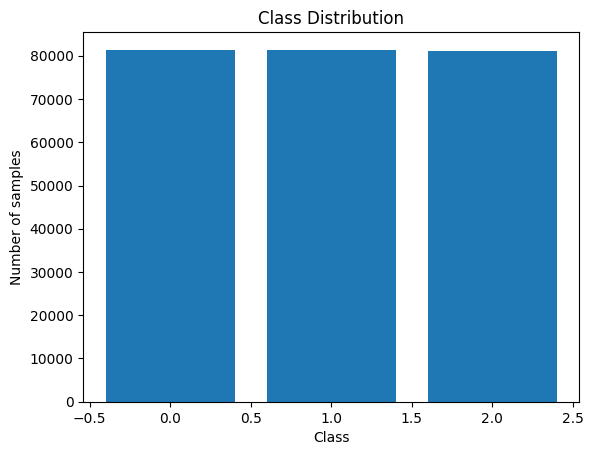

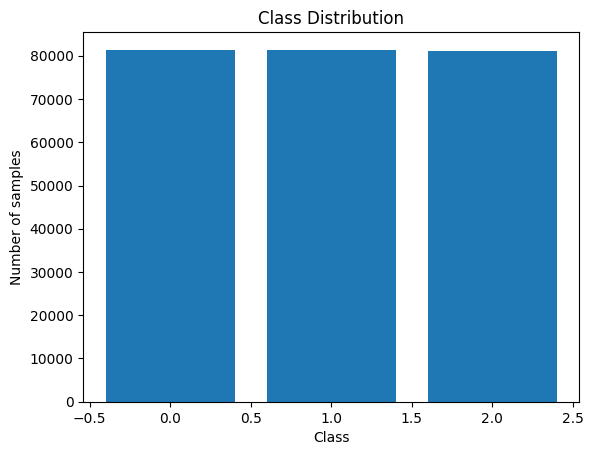

In [6]:
#Sampled_train = pd.read_csv("dataset/train.csv")
#Sampled_test = pd.read_csv("dataset/test.csv")
#Sampled_cv = pd.read_csv('dataset/cv.csv')

Sampled_train = pd.read_csv("/content/drive/MyDrive/Dataset_RP/traincsv.csv")
Sampled_train = pd.concat([Sampled_train,pd.read_csv("/content/drive/MyDrive/Dataset_RP/train12csv.csv")])

class_distribution = Sampled_train['faultNumber'].value_counts()
# Plotting the class distribution
plt.bar(class_distribution.index, class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class Distribution')
plt.show()

train_data = pd.DataFrame()
val_data = pd.DataFrame()
test_data = pd.DataFrame()

for i in range (3):
  for j in range (1,3):
    Sample_temp = Sampled_train[Sampled_train['faultNumber']==i]
    Sample_temp = Sample_temp[Sample_temp['simulationRun']==j]
    begin = 0
    train_size = int(((len(Sample_temp)) * 0.6)/20)
    val_size = int(((len(Sample_temp) * 0.2)/20))
    test_size = int(((len(Sample_temp) * 0.2)/20))

    for k in range (1,21):
      train_data =pd.concat([train_data,Sample_temp[begin:begin+train_size]])
      val_data = pd.concat([val_data,Sample_temp[begin+train_size:begin+train_size+val_size]])
      test_data = pd.concat([test_data,Sample_temp[begin+train_size+val_size:begin+train_size+val_size+test_size]])
      begin = begin+train_size+val_size+test_size
Sampled_train = train_data
Sampled_cv = val_data
Sampled_test = test_data

class_distribution = Sampled_train['faultNumber'].value_counts()
# Plotting the class distribution
plt.bar(class_distribution.index, class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class Distribution')
plt.show()

class_distribution = Sampled_cv['faultNumber'].value_counts()
# Plotting the class distribution
plt.bar(class_distribution.index, class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class Distribution')
plt.show()

class_distribution = Sampled_test['faultNumber'].value_counts()
# Plotting the class distribution
plt.bar(class_distribution.index, class_distribution.values)
plt.xlabel('Class')
plt.ylabel('Number of samples')
plt.title('Class Distribution')
plt.show()

#Sampled_train.to_csv("/content/drive/MyDrive/Dataset_RP/outputtrain.csv", index=True)
#Sampled_cv.to_csv("/content/drive/MyDrive/Dataset_RP/outputcv.csv", index=True)
#Sampled_test.to_csv("/content/drive/MyDrive/Dataset_RP/outputtest.csv", index=True)

In [7]:
Sampled_train

,faultNumber,simulationRun,sample,VelocityRef:1,<xdot>,<BattSoc>,<BattPwr>,<Cltch1State>,<Cltch2State>,<BattV>,...,<MotTrq>,<StartTrq>,StartCmd,MotTrqCmd,BattCrnt:1,MotPwrElec:1,MotPwrMech:1,IntkVlvLiftCmd,FuelMainSoi,FuelFlw
0,0,1,0.000000e+00,0.0,0.000000e+00,60.000000,0.000000e+00,0,1,272.952000,...,0.0,0.000000e+00,0,0.0,0.000000e+00,0.0,0.0,0,0,0.0
1,0,1,3.160000e-30,0.0,-3.100000e-94,60.000000,1.870000e-32,1,1,272.952000,...,0.0,-8.100000e-37,0,0.0,6.860000e-35,0.0,0.0,0,0,0.0
2,0,1,9.000000e-10,0.0,-3.100000e-94,60.000000,6.300000e-12,1,1,272.952000,...,0.0,-2.310000e-16,0,0.0,2.310000e-14,0.0,0.0,0,0,0.0
3,0,1,9.000000e-10,0.0,-3.100000e-94,60.000000,6.300000e-12,0,1,272.952000,...,0.0,-2.310000e-16,0,0.0,2.310000e-14,0.0,0.0,0,0,0.0
4,0,1,1.200000e-06,0.0,-3.100000e-94,60.000000,1.710000e-06,0,1,272.952000,...,0.0,1.030000e-13,0,0.0,6.250000e-09,0.0,0.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604591,2,2,9.796650e+02,0.0,-1.360000e-22,0.292693,0.000000e+00,0,0,210.619638,...,0.0,0.000000e+00,0,0.0,0.000000e+00,0.0,0.0,0,0,0.0
604592,2,2,9.796700e+02,0.0,-1.360000e-22,0.292693,0.000000e+00,0,0,210.619638,...,0.0,0.000000e+00,0,0.0,0.000000e+00,0.0,0.0,0,0,0.0
604593,2,2,9.796750e+02,0.0,-1.360000e-22,0.292693,0.000000e+00,0,0,210.619638,...,0.0,0.000000e+00,0,0.0,0.000000e+00,0.0,0.0,0,0,0.0
604594,2,2,9.796800e+02,0.0,-1.360000e-22,0.292693,0.000000e+00,0,0,210.619638,...,0.0,0.000000e+00,0,0.0,0.000000e+00,0.0,0.0,0,0,0.0


# Preprocessing

In [8]:
# Drop some mysterious fault type
Sampled_train.drop(Sampled_train[(Sampled_train.faultNumber == 3) | (Sampled_train.faultNumber == 9) | (Sampled_train.faultNumber == 15)].index, inplace = True)
Sampled_test.drop(Sampled_test[(Sampled_test.faultNumber == 3) | (Sampled_test.faultNumber == 9) | (Sampled_test.faultNumber == 15)].index, inplace = True)
Sampled_cv.drop(Sampled_cv[(Sampled_cv.faultNumber == 3) | (Sampled_cv.faultNumber == 9) | (Sampled_cv.faultNumber == 15)].index, inplace = True)

In [9]:
# make the Y value usable in LSTM
y_train = to_categorical(Sampled_train['faultNumber'],num_classes=3)
y_test = to_categorical(Sampled_test['faultNumber'],num_classes=3)
y_cv = to_categorical(Sampled_cv['faultNumber'],num_classes=3)

In [10]:
# Test if the dropping is successful
Sampled_cv[Sampled_cv['faultNumber'] == 1]
Sampled_train

,faultNumber,simulationRun,sample,VelocityRef:1,<xdot>,<BattSoc>,<BattPwr>,<Cltch1State>,<Cltch2State>,<BattV>,...,<MotTrq>,<StartTrq>,StartCmd,MotTrqCmd,BattCrnt:1,MotPwrElec:1,MotPwrMech:1,IntkVlvLiftCmd,FuelMainSoi,FuelFlw
0,0,1,0.000000e+00,0.0,0.000000e+00,60.000000,0.000000e+00,0,1,272.952000,...,0.0,0.000000e+00,0,0.0,0.000000e+00,0.0,0.0,0,0,0.0
1,0,1,3.160000e-30,0.0,-3.100000e-94,60.000000,1.870000e-32,1,1,272.952000,...,0.0,-8.100000e-37,0,0.0,6.860000e-35,0.0,0.0,0,0,0.0
2,0,1,9.000000e-10,0.0,-3.100000e-94,60.000000,6.300000e-12,1,1,272.952000,...,0.0,-2.310000e-16,0,0.0,2.310000e-14,0.0,0.0,0,0,0.0
3,0,1,9.000000e-10,0.0,-3.100000e-94,60.000000,6.300000e-12,0,1,272.952000,...,0.0,-2.310000e-16,0,0.0,2.310000e-14,0.0,0.0,0,0,0.0
4,0,1,1.200000e-06,0.0,-3.100000e-94,60.000000,1.710000e-06,0,1,272.952000,...,0.0,1.030000e-13,0,0.0,6.250000e-09,0.0,0.0,0,0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
604591,2,2,9.796650e+02,0.0,-1.360000e-22,0.292693,0.000000e+00,0,0,210.619638,...,0.0,0.000000e+00,0,0.0,0.000000e+00,0.0,0.0,0,0,0.0
604592,2,2,9.796700e+02,0.0,-1.360000e-22,0.292693,0.000000e+00,0,0,210.619638,...,0.0,0.000000e+00,0,0.0,0.000000e+00,0.0,0.0,0,0,0.0
604593,2,2,9.796750e+02,0.0,-1.360000e-22,0.292693,0.000000e+00,0,0,210.619638,...,0.0,0.000000e+00,0,0.0,0.000000e+00,0.0,0.0,0,0,0.0
604594,2,2,9.796800e+02,0.0,-1.360000e-22,0.292693,0.000000e+00,0,0,210.619638,...,0.0,0.000000e+00,0,0.0,0.000000e+00,0.0,0.0,0,0,0.0


In [11]:
x_train_df = Sampled_train.drop(['faultNumber','simulationRun','sample'],axis=1)
x_test_df = Sampled_test.drop(['faultNumber','simulationRun','sample'],axis =1)
x_cv_df = Sampled_cv.drop(['faultNumber','simulationRun','sample'],axis =1)

# Parameters and Utility Functions

In [12]:
feature_list = x_train_df.columns

In [13]:
def x_generator(masked, feature_name):
    # generate the needed x matrix for training, while keeping x_df intact

    dimension = dict()

    # row dimension
    dimension['train_row'] = len(x_train_df)
    dimension['test_row'] = len(x_test_df)
    dimension['cv_row'] = len(x_cv_df)

    # decide whether to mask a feature or not
    if masked == True:
        x_train_masked_df = x_train_df.drop([feature_name], axis = 1)
        x_test_masked_df = x_test_df.drop([feature_name], axis = 1)
        x_cv_masked_df = x_cv_df.drop([feature_name], axis = 1)
    else:
        x_train_masked_df = x_train_df.copy()
        x_test_masked_df = x_test_df.copy()
        x_cv_masked_df = x_cv_df.copy()

    # column dimension
    dimension['train_col'] = x_train_masked_df.shape[1]
    dimension['test_col'] = x_test_masked_df.shape[1]
    dimension['cv_col'] = x_cv_masked_df.shape[1]

    standard_scalar = StandardScaler()
    x_train_masked_df = standard_scalar.fit_transform(x_train_masked_df)
    x_test_masked_df = standard_scalar.transform(x_test_masked_df)
    x_cv_masked_df = standard_scalar.transform(x_cv_masked_df)

    x_train = np.resize(x_train_masked_df, (dimension['train_row'], dimension['train_col'], 1))
    x_test = np.resize(x_test_masked_df, (dimension['test_row'], dimension['test_col'], 1))
    x_cv = np.resize(x_cv_masked_df, (dimension['cv_row'], dimension['cv_col'], 1))

    return dimension, x_train, x_test, x_cv

In [14]:
def train_model(x_train, y_train, x_cv, y_cv, train_col, feature_name):
    model = Sequential()
    model.add(LSTM(256,input_shape= (train_col, 1),return_sequences= True))
    model.add(LSTM(128,return_sequences= False))
    model.add(Dense(300))
    model.add(Dropout(0.5))
    model.add(Dense(128))
    model.add(Dense(3,activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # training
    model.fit(x_train, y_train, epochs = 35, verbose=2,batch_size=256,validation_data = (x_cv, y_cv))

    # saving the model
    model.save('/content/drive/MyDrive/models/'+ feature_name)

    # saving the history
    model_paras = model.history
    with open('/content/drive/MyDrive/models/' + feature_name + '/history.pickle', 'wb') as handle:
        pickle.dump(model_paras.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

    return model

In [15]:
def visulize_model(history, feature_name):
    x = list(range(1,len(history['loss']) + 1))
    plt.figure(figsize=(5,5))
    plt.plot(x, history['val_accuracy'],color = 'r',label = 'Validation Accuracy')
    plt.plot(x, history['accuracy'],color = 'b',label = 'Training Accuracy')
    plt.grid()
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('accuracy')
    plt.savefig('/content/drive/MyDrive/models/' + feature_name + '/performance.png')
    plt.show()

# Training on complete features

In [16]:
dimension, x_train, x_test, x_cv = x_generator(masked = False, feature_name=None)

feature_name = 'complete'
complete_model = train_model(x_train, y_train, x_cv, y_cv, dimension['train_col'], feature_name)


Epoch 1/35
2856/2856 - 55s - loss: 0.5361 - accuracy: 0.6906 - val_loss: 0.5841 - val_accuracy: 0.6871 - 55s/epoch - 19ms/step
Epoch 2/35
2856/2856 - 47s - loss: 0.4262 - accuracy: 0.7504 - val_loss: 0.5672 - val_accuracy: 0.7285 - 47s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 47s - loss: 0.3768 - accuracy: 0.7851 - val_loss: 0.5719 - val_accuracy: 0.7452 - 47s/epoch - 17ms/step
Epoch 4/35
2856/2856 - 47s - loss: 0.3319 - accuracy: 0.8201 - val_loss: 0.6743 - val_accuracy: 0.7764 - 47s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 47s - loss: 0.2854 - accuracy: 0.8496 - val_loss: 0.7214 - val_accuracy: 0.7942 - 47s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 47s - loss: 0.2547 - accuracy: 0.8654 - val_loss: 0.6608 - val_accuracy: 0.7927 - 47s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 47s - loss: 0.2263 - accuracy: 0.8815 - val_loss: 0.7859 - val_accuracy: 0.7984 - 47s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 47s - loss: 0.2206 - accuracy: 0.8840 - val_loss: 0.7192 - val_accuracy: 0.8052 - 47s/ep

In [17]:
# load the history of the current model
with open('/content/drive/MyDrive/models/' + feature_name + '/history.pickle', "rb") as hisotry_file:
    history = pickle.load(hisotry_file)

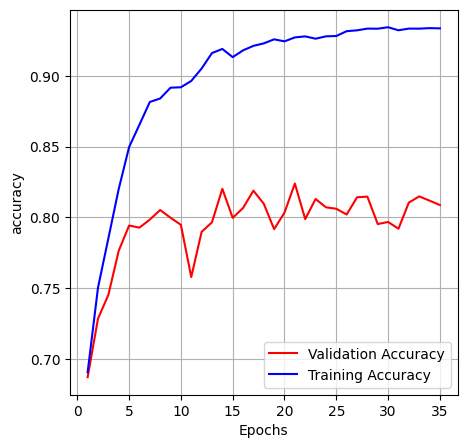

In [18]:
# saving the visulization
visulize_model(history, feature_name)

In [19]:
score, acc = complete_model.evaluate(x_test, y_test, verbose=0)
print('Test accuracy:', acc)
print("Test loss:", score)

Test accuracy: 0.8241976499557495
Test loss: 0.8617954850196838


In [20]:
complete_peak = max(history['val_accuracy'])
print(complete_peak)

0.8238816261291504


# Training with masked feature

In [21]:
already_masked = list()
counter = 0

In [22]:
len(feature_list)

32

VelocityRef:1
Epoch 1/35
2856/2856 - 55s - loss: 0.5471 - accuracy: 0.6818 - val_loss: 0.5549 - val_accuracy: 0.7040 - 55s/epoch - 19ms/step
Epoch 2/35
2856/2856 - 46s - loss: 0.4273 - accuracy: 0.7510 - val_loss: 0.5781 - val_accuracy: 0.7412 - 46s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 46s - loss: 0.3730 - accuracy: 0.7941 - val_loss: 0.6221 - val_accuracy: 0.7485 - 46s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 46s - loss: 0.3263 - accuracy: 0.8236 - val_loss: 0.5809 - val_accuracy: 0.7688 - 46s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 46s - loss: 0.2956 - accuracy: 0.8424 - val_loss: 0.5899 - val_accuracy: 0.7818 - 46s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 46s - loss: 0.2717 - accuracy: 0.8578 - val_loss: 0.7059 - val_accuracy: 0.7632 - 46s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 46s - loss: 0.2622 - accuracy: 0.8635 - val_loss: 0.7291 - val_accuracy: 0.7861 - 46s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 46s - loss: 0.2375 - accuracy: 0.8738 - val_loss: 0.7984 - val_accuracy: 0

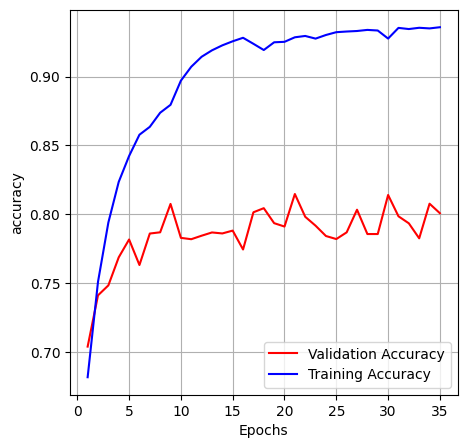


number:  1  feature name:  VelocityRef:1
<xdot>
Epoch 1/35
2856/2856 - 52s - loss: 0.5430 - accuracy: 0.6853 - val_loss: 0.5366 - val_accuracy: 0.7165 - 52s/epoch - 18ms/step
Epoch 2/35
2856/2856 - 45s - loss: 0.4325 - accuracy: 0.7511 - val_loss: 0.5416 - val_accuracy: 0.7661 - 45s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 45s - loss: 0.3702 - accuracy: 0.7953 - val_loss: 0.6425 - val_accuracy: 0.7622 - 45s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 45s - loss: 0.3127 - accuracy: 0.8335 - val_loss: 0.6320 - val_accuracy: 0.7498 - 45s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 46s - loss: 0.2680 - accuracy: 0.8604 - val_loss: 0.6537 - val_accuracy: 0.7991 - 46s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 46s - loss: 0.2374 - accuracy: 0.8757 - val_loss: 0.7388 - val_accuracy: 0.7993 - 46s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 45s - loss: 0.2288 - accuracy: 0.8802 - val_loss: 0.7820 - val_accuracy: 0.7950 - 45s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 46s - loss: 0.2151 - accuracy: 0.8896 -

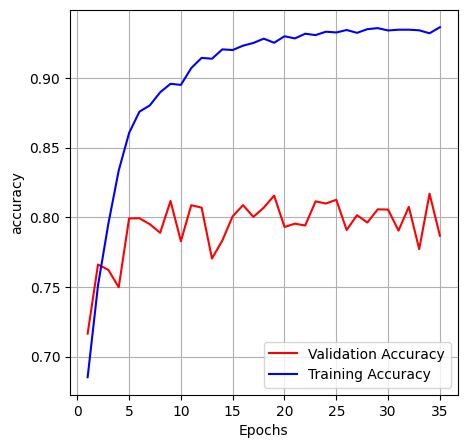


number:  2  feature name:  <xdot>
<BattSoc>
Epoch 1/35
2856/2856 - 53s - loss: 0.5747 - accuracy: 0.6730 - val_loss: 0.5497 - val_accuracy: 0.7154 - 53s/epoch - 19ms/step
Epoch 2/35
2856/2856 - 45s - loss: 0.4449 - accuracy: 0.7421 - val_loss: 0.6223 - val_accuracy: 0.7155 - 45s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 46s - loss: 0.3951 - accuracy: 0.7739 - val_loss: 0.5795 - val_accuracy: 0.7742 - 46s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 46s - loss: 0.3577 - accuracy: 0.7982 - val_loss: 0.6270 - val_accuracy: 0.7636 - 46s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 46s - loss: 0.3354 - accuracy: 0.8145 - val_loss: 0.6761 - val_accuracy: 0.7930 - 46s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 46s - loss: 0.3011 - accuracy: 0.8341 - val_loss: 0.8020 - val_accuracy: 0.7798 - 46s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 46s - loss: 0.2818 - accuracy: 0.8446 - val_loss: 0.7195 - val_accuracy: 0.8100 - 46s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 46s - loss: 0.2638 - accuracy: 0.8544 - val

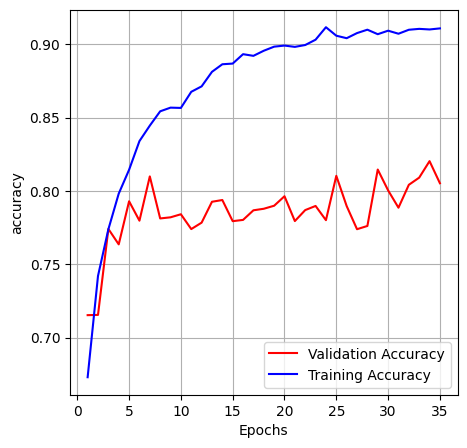


number:  3  feature name:  <BattSoc>
<BattPwr>
Epoch 1/35
2856/2856 - 51s - loss: 0.5396 - accuracy: 0.6892 - val_loss: 0.6185 - val_accuracy: 0.7121 - 51s/epoch - 18ms/step
Epoch 2/35
2856/2856 - 45s - loss: 0.4107 - accuracy: 0.7612 - val_loss: 0.5958 - val_accuracy: 0.7178 - 45s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 46s - loss: 0.3636 - accuracy: 0.7975 - val_loss: 0.5879 - val_accuracy: 0.7382 - 46s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 46s - loss: 0.3382 - accuracy: 0.8139 - val_loss: 0.7601 - val_accuracy: 0.7643 - 46s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 46s - loss: 0.3060 - accuracy: 0.8355 - val_loss: 0.7444 - val_accuracy: 0.7758 - 46s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 46s - loss: 0.2924 - accuracy: 0.8391 - val_loss: 0.6616 - val_accuracy: 0.7314 - 46s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 46s - loss: 0.2542 - accuracy: 0.8626 - val_loss: 0.7838 - val_accuracy: 0.7749 - 46s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 46s - loss: 0.2303 - accuracy: 0.8783 - 

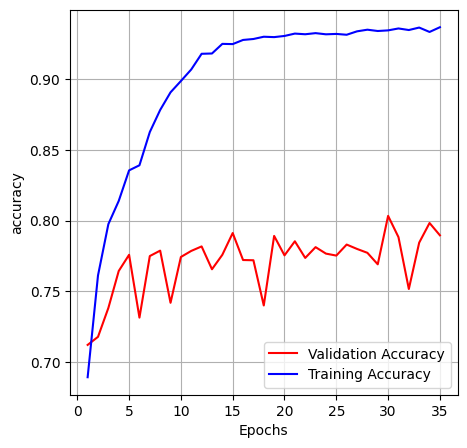


number:  4  feature name:  <BattPwr>
<Cltch1State>
Epoch 1/35
2856/2856 - 51s - loss: 0.5319 - accuracy: 0.6923 - val_loss: 0.5648 - val_accuracy: 0.7097 - 51s/epoch - 18ms/step
Epoch 2/35
2856/2856 - 45s - loss: 0.4172 - accuracy: 0.7576 - val_loss: 0.5513 - val_accuracy: 0.7388 - 45s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 45s - loss: 0.3719 - accuracy: 0.7917 - val_loss: 0.5644 - val_accuracy: 0.7541 - 45s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 46s - loss: 0.3292 - accuracy: 0.8219 - val_loss: 0.5909 - val_accuracy: 0.7754 - 46s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 45s - loss: 0.2959 - accuracy: 0.8442 - val_loss: 0.6331 - val_accuracy: 0.7719 - 45s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 45s - loss: 0.2522 - accuracy: 0.8688 - val_loss: 0.6802 - val_accuracy: 0.7919 - 45s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 46s - loss: 0.2383 - accuracy: 0.8764 - val_loss: 0.5977 - val_accuracy: 0.8086 - 46s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 46s - loss: 0.2239 - accuracy: 0.883

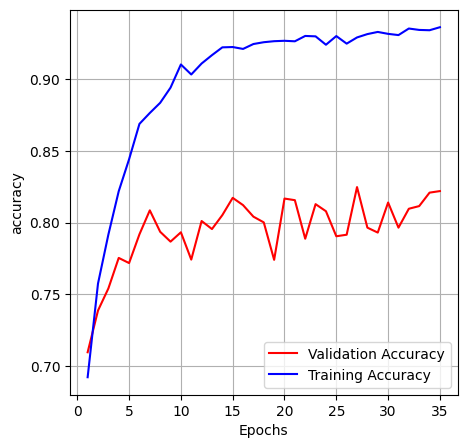


number:  5  feature name:  <Cltch1State>
<Cltch2State>
Epoch 1/35
2856/2856 - 52s - loss: 0.5406 - accuracy: 0.6895 - val_loss: 0.5792 - val_accuracy: 0.7025 - 52s/epoch - 18ms/step
Epoch 2/35
2856/2856 - 46s - loss: 0.4425 - accuracy: 0.7479 - val_loss: 0.5537 - val_accuracy: 0.7377 - 46s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 45s - loss: 0.3867 - accuracy: 0.7857 - val_loss: 0.6105 - val_accuracy: 0.7454 - 45s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 45s - loss: 0.3282 - accuracy: 0.8252 - val_loss: 0.6051 - val_accuracy: 0.7700 - 45s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 45s - loss: 0.2818 - accuracy: 0.8542 - val_loss: 0.6786 - val_accuracy: 0.7743 - 45s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 46s - loss: 0.2569 - accuracy: 0.8653 - val_loss: 0.6740 - val_accuracy: 0.8020 - 46s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 46s - loss: 0.2246 - accuracy: 0.8857 - val_loss: 0.7761 - val_accuracy: 0.7817 - 46s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 46s - loss: 0.2031 - accuracy: 0

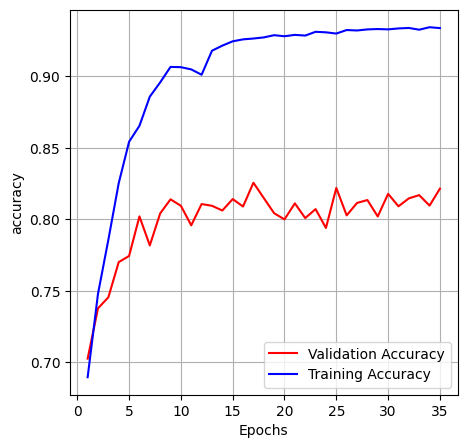


number:  6  feature name:  <Cltch2State>
<BattV>
Epoch 1/35
2856/2856 - 52s - loss: 0.5360 - accuracy: 0.6883 - val_loss: 0.5608 - val_accuracy: 0.6958 - 52s/epoch - 18ms/step
Epoch 2/35
2856/2856 - 45s - loss: 0.4313 - accuracy: 0.7464 - val_loss: 0.5945 - val_accuracy: 0.7201 - 45s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 46s - loss: 0.3913 - accuracy: 0.7742 - val_loss: 0.5833 - val_accuracy: 0.7483 - 46s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 46s - loss: 0.3428 - accuracy: 0.8100 - val_loss: 0.6312 - val_accuracy: 0.7580 - 46s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 46s - loss: 0.2992 - accuracy: 0.8404 - val_loss: 0.5821 - val_accuracy: 0.7918 - 46s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 45s - loss: 0.2539 - accuracy: 0.8661 - val_loss: 0.6746 - val_accuracy: 0.8071 - 45s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 45s - loss: 0.2398 - accuracy: 0.8741 - val_loss: 0.7189 - val_accuracy: 0.7989 - 45s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 46s - loss: 0.2094 - accuracy: 0.8873 

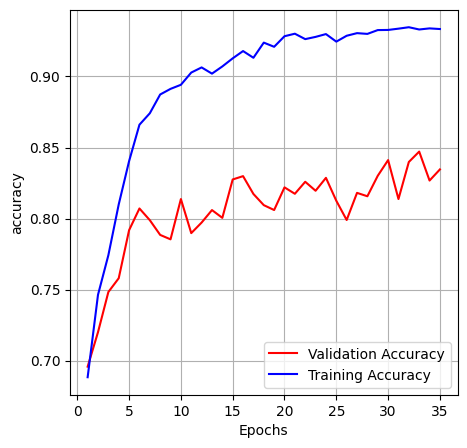


number:  7  feature name:  <BattV>
<TransGear>
Epoch 1/35
2856/2856 - 52s - loss: 0.5393 - accuracy: 0.6890 - val_loss: 0.5616 - val_accuracy: 0.7126 - 52s/epoch - 18ms/step
Epoch 2/35
2856/2856 - 45s - loss: 0.4304 - accuracy: 0.7503 - val_loss: 0.6187 - val_accuracy: 0.7272 - 45s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 46s - loss: 0.3776 - accuracy: 0.7868 - val_loss: 0.5671 - val_accuracy: 0.7475 - 46s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 45s - loss: 0.3285 - accuracy: 0.8203 - val_loss: 0.6293 - val_accuracy: 0.7438 - 45s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 45s - loss: 0.2924 - accuracy: 0.8439 - val_loss: 0.7335 - val_accuracy: 0.7924 - 45s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 46s - loss: 0.2522 - accuracy: 0.8676 - val_loss: 0.6794 - val_accuracy: 0.7738 - 46s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 45s - loss: 0.2142 - accuracy: 0.8868 - val_loss: 0.7688 - val_accuracy: 0.8027 - 45s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 46s - loss: 0.1937 - accuracy: 0.8984 - 

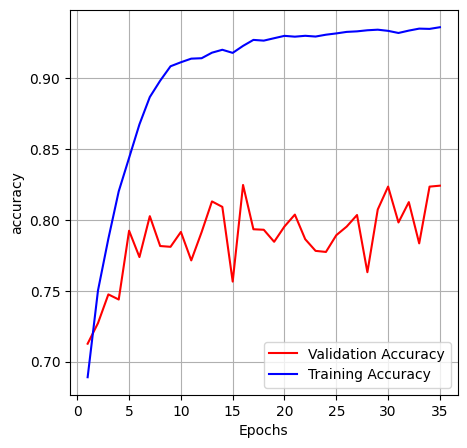


number:  8  feature name:  <TransGear>
<EngSpd>
Epoch 1/35
2856/2856 - 51s - loss: 0.5395 - accuracy: 0.6895 - val_loss: 0.5722 - val_accuracy: 0.6962 - 51s/epoch - 18ms/step
Epoch 2/35
2856/2856 - 45s - loss: 0.4212 - accuracy: 0.7520 - val_loss: 0.5762 - val_accuracy: 0.7506 - 45s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 45s - loss: 0.3693 - accuracy: 0.7891 - val_loss: 0.5839 - val_accuracy: 0.7952 - 45s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 45s - loss: 0.3254 - accuracy: 0.8201 - val_loss: 0.7055 - val_accuracy: 0.7426 - 45s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 46s - loss: 0.2626 - accuracy: 0.8588 - val_loss: 0.7110 - val_accuracy: 0.7813 - 46s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 45s - loss: 0.2396 - accuracy: 0.8719 - val_loss: 0.9210 - val_accuracy: 0.7848 - 45s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 46s - loss: 0.2180 - accuracy: 0.8832 - val_loss: 0.6689 - val_accuracy: 0.7770 - 46s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 45s - loss: 0.2164 - accuracy: 0.8869 -

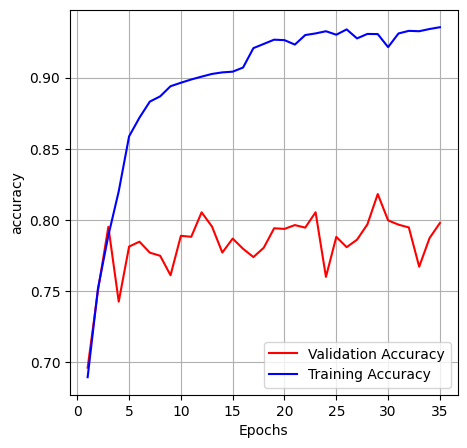


number:  9  feature name:  <EngSpd>
<IntkVlvLift>
Epoch 1/35
2856/2856 - 53s - loss: 0.5407 - accuracy: 0.6869 - val_loss: 0.5403 - val_accuracy: 0.7123 - 53s/epoch - 19ms/step
Epoch 2/35
2856/2856 - 45s - loss: 0.4209 - accuracy: 0.7567 - val_loss: 0.5719 - val_accuracy: 0.7246 - 45s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 45s - loss: 0.3660 - accuracy: 0.7974 - val_loss: 0.6240 - val_accuracy: 0.7570 - 45s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 45s - loss: 0.3223 - accuracy: 0.8260 - val_loss: 0.6378 - val_accuracy: 0.7659 - 45s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 46s - loss: 0.2794 - accuracy: 0.8510 - val_loss: 0.5884 - val_accuracy: 0.7848 - 46s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 45s - loss: 0.2455 - accuracy: 0.8696 - val_loss: 0.6858 - val_accuracy: 0.8005 - 45s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 45s - loss: 0.2339 - accuracy: 0.8775 - val_loss: 0.7687 - val_accuracy: 0.7878 - 45s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 45s - loss: 0.2106 - accuracy: 0.8898

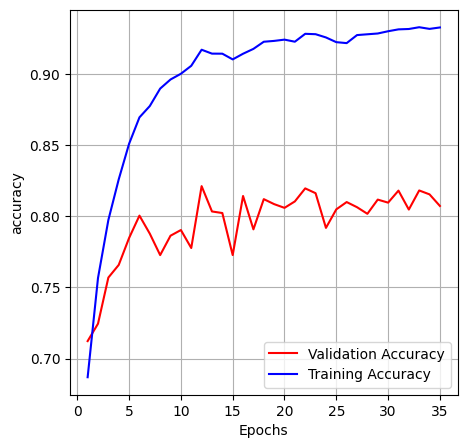


number:  10  feature name:  <IntkVlvLift>
<EngTrq>
Epoch 1/35
2856/2856 - 52s - loss: 0.5542 - accuracy: 0.6806 - val_loss: 0.5636 - val_accuracy: 0.7116 - 52s/epoch - 18ms/step
Epoch 2/35
2856/2856 - 45s - loss: 0.4334 - accuracy: 0.7466 - val_loss: 0.5535 - val_accuracy: 0.7282 - 45s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 46s - loss: 0.3848 - accuracy: 0.7831 - val_loss: 0.5834 - val_accuracy: 0.7482 - 46s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 45s - loss: 0.3369 - accuracy: 0.8165 - val_loss: 0.6029 - val_accuracy: 0.7738 - 45s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 45s - loss: 0.2802 - accuracy: 0.8507 - val_loss: 0.7766 - val_accuracy: 0.8100 - 45s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 45s - loss: 0.2595 - accuracy: 0.8660 - val_loss: 0.6876 - val_accuracy: 0.7681 - 45s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 45s - loss: 0.2202 - accuracy: 0.8867 - val_loss: 0.6885 - val_accuracy: 0.7726 - 45s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 45s - loss: 0.1961 - accuracy: 0.898

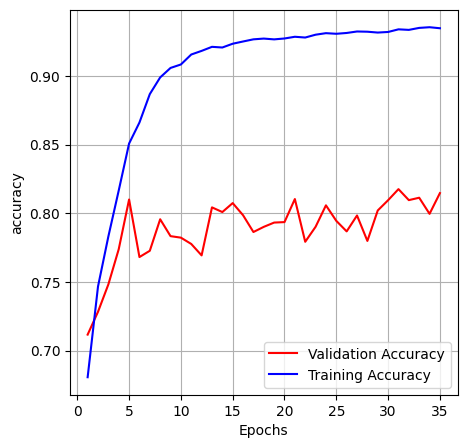


number:  11  feature name:  <EngTrq>
<ThrPosPct>
Epoch 1/35
2856/2856 - 52s - loss: 0.5513 - accuracy: 0.6815 - val_loss: 0.5501 - val_accuracy: 0.6937 - 52s/epoch - 18ms/step
Epoch 2/35
2856/2856 - 46s - loss: 0.4424 - accuracy: 0.7415 - val_loss: 0.5830 - val_accuracy: 0.7371 - 46s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 46s - loss: 0.3972 - accuracy: 0.7747 - val_loss: 0.6784 - val_accuracy: 0.7492 - 46s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 45s - loss: 0.3441 - accuracy: 0.8105 - val_loss: 0.7225 - val_accuracy: 0.7623 - 45s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 45s - loss: 0.2967 - accuracy: 0.8409 - val_loss: 0.7494 - val_accuracy: 0.7727 - 45s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 45s - loss: 0.2597 - accuracy: 0.8617 - val_loss: 0.7376 - val_accuracy: 0.7512 - 45s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 46s - loss: 0.2501 - accuracy: 0.8670 - val_loss: 0.7108 - val_accuracy: 0.7946 - 46s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 46s - loss: 0.2248 - accuracy: 0.8790 

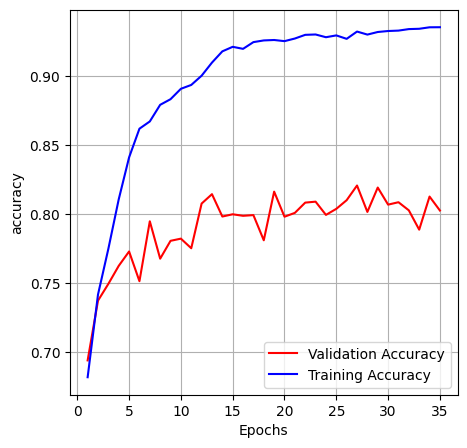


number:  12  feature name:  <ThrPosPct>
<WgAreaPct>
Epoch 1/35
2856/2856 - 52s - loss: 0.5396 - accuracy: 0.6881 - val_loss: 0.6083 - val_accuracy: 0.6842 - 52s/epoch - 18ms/step
Epoch 2/35
2856/2856 - 45s - loss: 0.4393 - accuracy: 0.7432 - val_loss: 0.5877 - val_accuracy: 0.7381 - 45s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 45s - loss: 0.3857 - accuracy: 0.7809 - val_loss: 0.5904 - val_accuracy: 0.7349 - 45s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 46s - loss: 0.3442 - accuracy: 0.8103 - val_loss: 0.6459 - val_accuracy: 0.7406 - 46s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 46s - loss: 0.2981 - accuracy: 0.8389 - val_loss: 0.6657 - val_accuracy: 0.7591 - 46s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 46s - loss: 0.2621 - accuracy: 0.8614 - val_loss: 0.7463 - val_accuracy: 0.7869 - 46s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 46s - loss: 0.2294 - accuracy: 0.8793 - val_loss: 0.9200 - val_accuracy: 0.7951 - 46s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 46s - loss: 0.2049 - accuracy: 0.89

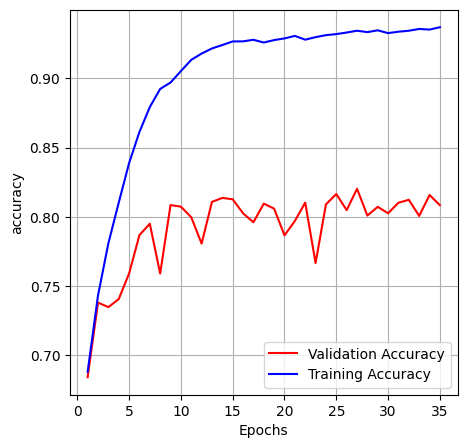


number:  13  feature name:  <WgAreaPct>
<EgrVlvAreaPct>
Epoch 1/35
2856/2856 - 53s - loss: 0.5399 - accuracy: 0.6887 - val_loss: 0.5680 - val_accuracy: 0.7011 - 53s/epoch - 19ms/step
Epoch 2/35
2856/2856 - 45s - loss: 0.4282 - accuracy: 0.7511 - val_loss: 0.5981 - val_accuracy: 0.7173 - 45s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 46s - loss: 0.3775 - accuracy: 0.7861 - val_loss: 0.5780 - val_accuracy: 0.7456 - 46s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 46s - loss: 0.3429 - accuracy: 0.8109 - val_loss: 0.5913 - val_accuracy: 0.7616 - 46s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 46s - loss: 0.3062 - accuracy: 0.8348 - val_loss: 0.7341 - val_accuracy: 0.7587 - 46s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 46s - loss: 0.2738 - accuracy: 0.8563 - val_loss: 0.6714 - val_accuracy: 0.7533 - 46s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 46s - loss: 0.2404 - accuracy: 0.8751 - val_loss: 0.6391 - val_accuracy: 0.7833 - 46s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 46s - loss: 0.2176 - accuracy: 

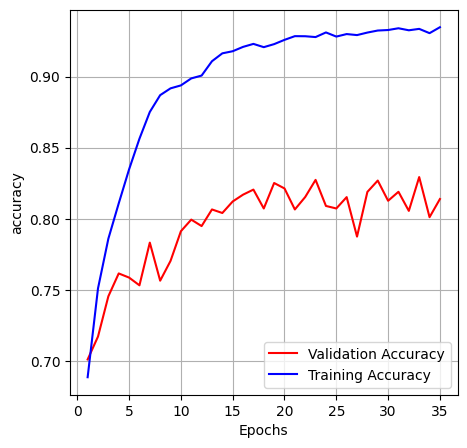


number:  14  feature name:  <EgrVlvAreaPct>
<VarCompRatioPos>
Epoch 1/35
2856/2856 - 51s - loss: 0.5442 - accuracy: 0.6850 - val_loss: 0.5311 - val_accuracy: 0.7158 - 51s/epoch - 18ms/step
Epoch 2/35
2856/2856 - 45s - loss: 0.4306 - accuracy: 0.7489 - val_loss: 0.5786 - val_accuracy: 0.7166 - 45s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 45s - loss: 0.3836 - accuracy: 0.7819 - val_loss: 0.6336 - val_accuracy: 0.7241 - 45s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 45s - loss: 0.3378 - accuracy: 0.8130 - val_loss: 0.6699 - val_accuracy: 0.7519 - 45s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 45s - loss: 0.2882 - accuracy: 0.8450 - val_loss: 0.6560 - val_accuracy: 0.7642 - 45s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 45s - loss: 0.2570 - accuracy: 0.8615 - val_loss: 0.6966 - val_accuracy: 0.7648 - 45s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 45s - loss: 0.2339 - accuracy: 0.8760 - val_loss: 0.7274 - val_accuracy: 0.7730 - 45s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 45s - loss: 0.2111 - accu

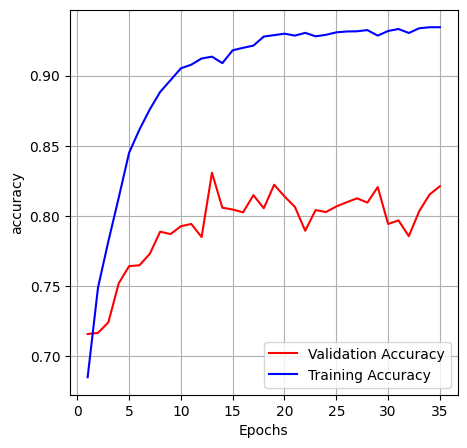


number:  15  feature name:  <VarCompRatioPos>
<Acc>
Epoch 1/35
2856/2856 - 53s - loss: 0.5412 - accuracy: 0.6918 - val_loss: 0.5768 - val_accuracy: 0.7206 - 53s/epoch - 19ms/step
Epoch 2/35
2856/2856 - 46s - loss: 0.4195 - accuracy: 0.7551 - val_loss: 0.5764 - val_accuracy: 0.7334 - 46s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 46s - loss: 0.3811 - accuracy: 0.7800 - val_loss: 0.6076 - val_accuracy: 0.7083 - 46s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 47s - loss: 0.3460 - accuracy: 0.8028 - val_loss: 0.7787 - val_accuracy: 0.7613 - 47s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 46s - loss: 0.2986 - accuracy: 0.8346 - val_loss: 0.8178 - val_accuracy: 0.7640 - 46s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 46s - loss: 0.2585 - accuracy: 0.8617 - val_loss: 0.6600 - val_accuracy: 0.7744 - 46s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 46s - loss: 0.2237 - accuracy: 0.8840 - val_loss: 0.8570 - val_accuracy: 0.7840 - 46s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 46s - loss: 0.1890 - accuracy: 0.90

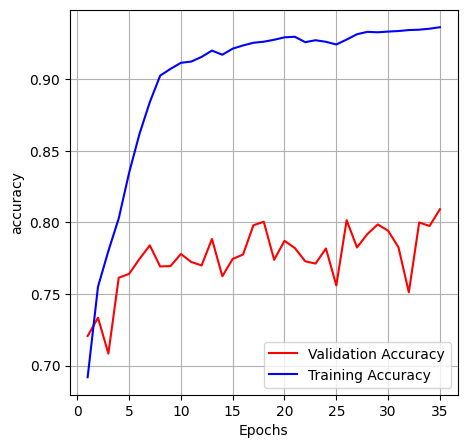


number:  16  feature name:  <Acc>
<Dec>
Epoch 1/35
2856/2856 - 52s - loss: 0.5410 - accuracy: 0.6877 - val_loss: 0.5540 - val_accuracy: 0.7119 - 52s/epoch - 18ms/step
Epoch 2/35
2856/2856 - 46s - loss: 0.4315 - accuracy: 0.7494 - val_loss: 0.5996 - val_accuracy: 0.7112 - 46s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 46s - loss: 0.3750 - accuracy: 0.7890 - val_loss: 0.6162 - val_accuracy: 0.7530 - 46s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 46s - loss: 0.3410 - accuracy: 0.8110 - val_loss: 0.6533 - val_accuracy: 0.7680 - 46s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 46s - loss: 0.2936 - accuracy: 0.8442 - val_loss: 0.7561 - val_accuracy: 0.7684 - 46s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 46s - loss: 0.2457 - accuracy: 0.8731 - val_loss: 0.8990 - val_accuracy: 0.7939 - 46s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 46s - loss: 0.2039 - accuracy: 0.8951 - val_loss: 0.7485 - val_accuracy: 0.7927 - 46s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 46s - loss: 0.2098 - accuracy: 0.8886 - val_los

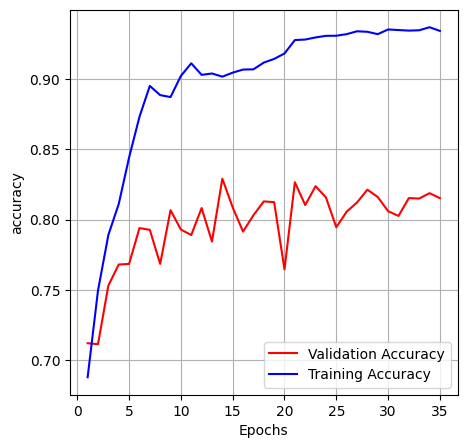


number:  17  feature name:  <Dec>
<IgSw>
Epoch 1/35
2856/2856 - 53s - loss: 0.5427 - accuracy: 0.6850 - val_loss: 0.6200 - val_accuracy: 0.6758 - 53s/epoch - 19ms/step
Epoch 2/35
2856/2856 - 46s - loss: 0.4324 - accuracy: 0.7473 - val_loss: 0.5581 - val_accuracy: 0.7120 - 46s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 46s - loss: 0.3891 - accuracy: 0.7792 - val_loss: 0.6307 - val_accuracy: 0.7097 - 46s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 46s - loss: 0.3486 - accuracy: 0.8075 - val_loss: 0.5599 - val_accuracy: 0.7801 - 46s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 46s - loss: 0.3074 - accuracy: 0.8353 - val_loss: 0.7216 - val_accuracy: 0.7540 - 46s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 46s - loss: 0.2787 - accuracy: 0.8516 - val_loss: 0.7279 - val_accuracy: 0.7774 - 46s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 46s - loss: 0.2583 - accuracy: 0.8636 - val_loss: 0.6208 - val_accuracy: 0.7768 - 46s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 46s - loss: 0.2399 - accuracy: 0.8774 - val_lo

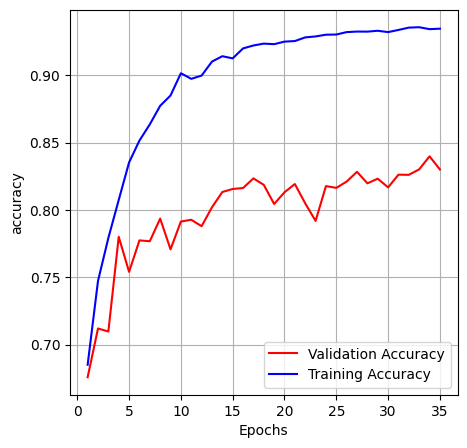


number:  18  feature name:  <IgSw>
<Chrg>
Epoch 1/35
2856/2856 - 54s - loss: 0.5373 - accuracy: 0.6908 - val_loss: 0.5476 - val_accuracy: 0.7321 - 54s/epoch - 19ms/step
Epoch 2/35
2856/2856 - 46s - loss: 0.4247 - accuracy: 0.7536 - val_loss: 0.5780 - val_accuracy: 0.7159 - 46s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 47s - loss: 0.3770 - accuracy: 0.7872 - val_loss: 0.5906 - val_accuracy: 0.7470 - 47s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 46s - loss: 0.3412 - accuracy: 0.8133 - val_loss: 0.5612 - val_accuracy: 0.7509 - 46s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 46s - loss: 0.2877 - accuracy: 0.8469 - val_loss: 0.6776 - val_accuracy: 0.7822 - 46s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 46s - loss: 0.2498 - accuracy: 0.8677 - val_loss: 0.7894 - val_accuracy: 0.7817 - 46s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 46s - loss: 0.2417 - accuracy: 0.8733 - val_loss: 0.7744 - val_accuracy: 0.7809 - 46s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 46s - loss: 0.2127 - accuracy: 0.8892 - val_l

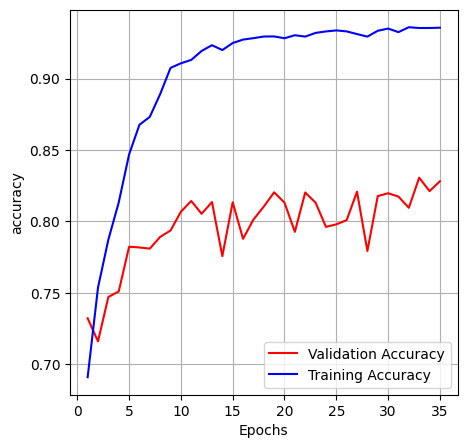


number:  19  feature name:  <Chrg>
TransGear
Epoch 1/35
2856/2856 - 52s - loss: 0.5335 - accuracy: 0.6930 - val_loss: 0.5821 - val_accuracy: 0.7102 - 52s/epoch - 18ms/step
Epoch 2/35
2856/2856 - 46s - loss: 0.4274 - accuracy: 0.7545 - val_loss: 0.5559 - val_accuracy: 0.7298 - 46s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 46s - loss: 0.3805 - accuracy: 0.7877 - val_loss: 0.5852 - val_accuracy: 0.7615 - 46s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 46s - loss: 0.3331 - accuracy: 0.8176 - val_loss: 0.6524 - val_accuracy: 0.7682 - 46s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 46s - loss: 0.3018 - accuracy: 0.8365 - val_loss: 0.6684 - val_accuracy: 0.7753 - 46s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 46s - loss: 0.2714 - accuracy: 0.8553 - val_loss: 0.6158 - val_accuracy: 0.7737 - 46s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 46s - loss: 0.2529 - accuracy: 0.8662 - val_loss: 0.8066 - val_accuracy: 0.7814 - 46s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 46s - loss: 0.2189 - accuracy: 0.8856 - va

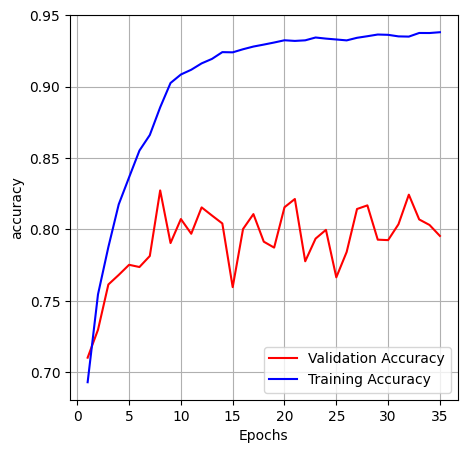


number:  20  feature name:  TransGear
BrkCmd
Epoch 1/35
2856/2856 - 53s - loss: 0.5357 - accuracy: 0.6928 - val_loss: 0.5933 - val_accuracy: 0.6935 - 53s/epoch - 18ms/step
Epoch 2/35
2856/2856 - 46s - loss: 0.4229 - accuracy: 0.7566 - val_loss: 0.5407 - val_accuracy: 0.7369 - 46s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 46s - loss: 0.3647 - accuracy: 0.7967 - val_loss: 0.5871 - val_accuracy: 0.7700 - 46s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 46s - loss: 0.3271 - accuracy: 0.8217 - val_loss: 0.6947 - val_accuracy: 0.7540 - 46s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 46s - loss: 0.2819 - accuracy: 0.8509 - val_loss: 0.6754 - val_accuracy: 0.7913 - 46s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 46s - loss: 0.2558 - accuracy: 0.8667 - val_loss: 0.7077 - val_accuracy: 0.7994 - 46s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 46s - loss: 0.2247 - accuracy: 0.8847 - val_loss: 0.6907 - val_accuracy: 0.7919 - 46s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 46s - loss: 0.2279 - accuracy: 0.8831 - va

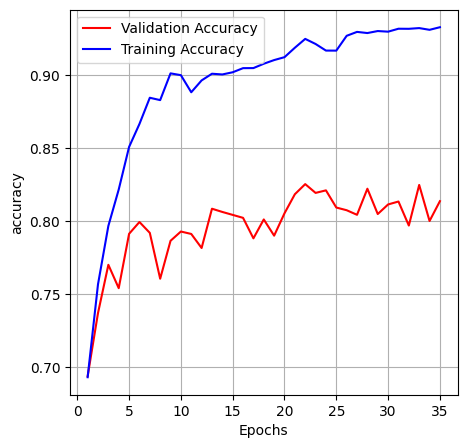


number:  21  feature name:  BrkCmd
Cltch1Cmd
Epoch 1/35
2856/2856 - 53s - loss: 0.5357 - accuracy: 0.6894 - val_loss: 0.5455 - val_accuracy: 0.7069 - 53s/epoch - 19ms/step
Epoch 2/35
2856/2856 - 46s - loss: 0.4241 - accuracy: 0.7551 - val_loss: 0.5544 - val_accuracy: 0.7387 - 46s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 46s - loss: 0.3757 - accuracy: 0.7898 - val_loss: 0.6160 - val_accuracy: 0.7376 - 46s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 46s - loss: 0.3337 - accuracy: 0.8170 - val_loss: 0.5789 - val_accuracy: 0.7590 - 46s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 46s - loss: 0.3050 - accuracy: 0.8357 - val_loss: 0.6944 - val_accuracy: 0.7484 - 46s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 46s - loss: 0.2705 - accuracy: 0.8578 - val_loss: 0.6929 - val_accuracy: 0.7619 - 46s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 46s - loss: 0.2547 - accuracy: 0.8659 - val_loss: 0.7663 - val_accuracy: 0.7845 - 46s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 46s - loss: 0.2283 - accuracy: 0.8782 - va

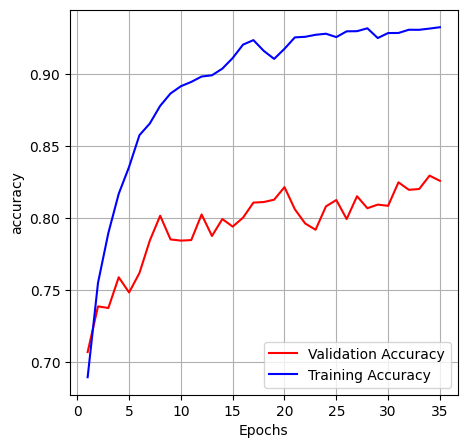


number:  22  feature name:  Cltch1Cmd
<MotTrq>
Epoch 1/35
2856/2856 - 52s - loss: 0.5619 - accuracy: 0.6737 - val_loss: 0.5931 - val_accuracy: 0.6997 - 52s/epoch - 18ms/step
Epoch 2/35
2856/2856 - 46s - loss: 0.4383 - accuracy: 0.7443 - val_loss: 0.5712 - val_accuracy: 0.7098 - 46s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 46s - loss: 0.3822 - accuracy: 0.7850 - val_loss: 0.5787 - val_accuracy: 0.7530 - 46s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 46s - loss: 0.3247 - accuracy: 0.8261 - val_loss: 0.6038 - val_accuracy: 0.7344 - 46s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 46s - loss: 0.2739 - accuracy: 0.8566 - val_loss: 0.7412 - val_accuracy: 0.7619 - 46s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 46s - loss: 0.2346 - accuracy: 0.8750 - val_loss: 0.7496 - val_accuracy: 0.7904 - 46s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 46s - loss: 0.2349 - accuracy: 0.8756 - val_loss: 0.7560 - val_accuracy: 0.7836 - 46s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 46s - loss: 0.2361 - accuracy: 0.8746 - 

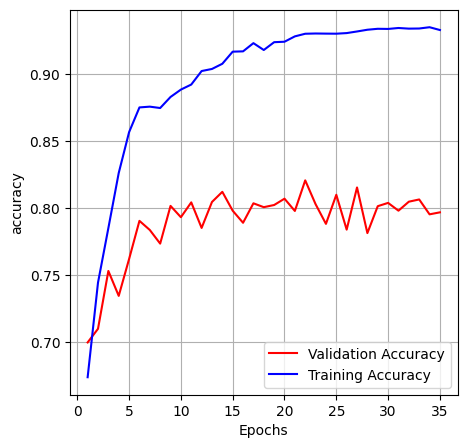


number:  23  feature name:  <MotTrq>
<StartTrq>
Epoch 1/35
2856/2856 - 53s - loss: 0.5403 - accuracy: 0.6857 - val_loss: 0.5628 - val_accuracy: 0.7094 - 53s/epoch - 18ms/step
Epoch 2/35
2856/2856 - 46s - loss: 0.4298 - accuracy: 0.7504 - val_loss: 0.5461 - val_accuracy: 0.7467 - 46s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 46s - loss: 0.3801 - accuracy: 0.7874 - val_loss: 0.6405 - val_accuracy: 0.7640 - 46s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 46s - loss: 0.3314 - accuracy: 0.8200 - val_loss: 0.6550 - val_accuracy: 0.7746 - 46s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 46s - loss: 0.2915 - accuracy: 0.8450 - val_loss: 0.7105 - val_accuracy: 0.7807 - 46s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 46s - loss: 0.2449 - accuracy: 0.8721 - val_loss: 0.7273 - val_accuracy: 0.7902 - 46s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 46s - loss: 0.2158 - accuracy: 0.8866 - val_loss: 0.6538 - val_accuracy: 0.7905 - 46s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 46s - loss: 0.1993 - accuracy: 0.8932 -

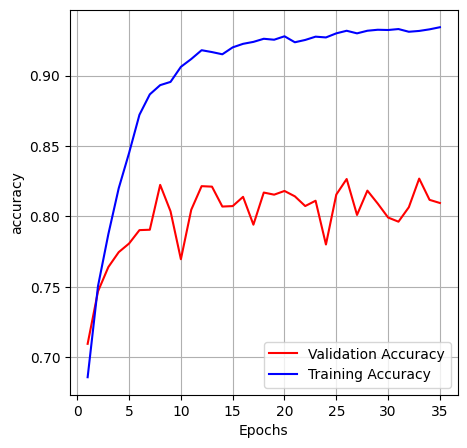


number:  24  feature name:  <StartTrq>
StartCmd
Epoch 1/35
2856/2856 - 52s - loss: 0.5397 - accuracy: 0.6888 - val_loss: 0.5549 - val_accuracy: 0.7031 - 52s/epoch - 18ms/step
Epoch 2/35
2856/2856 - 46s - loss: 0.4319 - accuracy: 0.7501 - val_loss: 0.5761 - val_accuracy: 0.7303 - 46s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 46s - loss: 0.3784 - accuracy: 0.7881 - val_loss: 0.6482 - val_accuracy: 0.7407 - 46s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 46s - loss: 0.3378 - accuracy: 0.8145 - val_loss: 0.6250 - val_accuracy: 0.7697 - 46s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 46s - loss: 0.2949 - accuracy: 0.8422 - val_loss: 0.5902 - val_accuracy: 0.7774 - 46s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 47s - loss: 0.2651 - accuracy: 0.8605 - val_loss: 0.6980 - val_accuracy: 0.7795 - 47s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 46s - loss: 0.2403 - accuracy: 0.8718 - val_loss: 0.6655 - val_accuracy: 0.7763 - 46s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 47s - loss: 0.2429 - accuracy: 0.8725 -

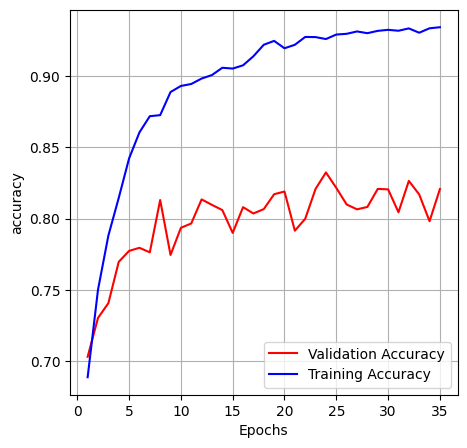


number:  25  feature name:  StartCmd
MotTrqCmd
Epoch 1/35
2856/2856 - 55s - loss: 0.5319 - accuracy: 0.6927 - val_loss: 0.5647 - val_accuracy: 0.6909 - 55s/epoch - 19ms/step
Epoch 2/35
2856/2856 - 47s - loss: 0.4244 - accuracy: 0.7547 - val_loss: 0.6217 - val_accuracy: 0.7343 - 47s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 48s - loss: 0.3737 - accuracy: 0.7913 - val_loss: 0.5740 - val_accuracy: 0.7433 - 48s/epoch - 17ms/step
Epoch 4/35
2856/2856 - 49s - loss: 0.3242 - accuracy: 0.8261 - val_loss: 0.6291 - val_accuracy: 0.7375 - 49s/epoch - 17ms/step
Epoch 5/35
2856/2856 - 49s - loss: 0.2851 - accuracy: 0.8489 - val_loss: 0.7694 - val_accuracy: 0.7696 - 49s/epoch - 17ms/step
Epoch 6/35
2856/2856 - 49s - loss: 0.2590 - accuracy: 0.8641 - val_loss: 0.7341 - val_accuracy: 0.7786 - 49s/epoch - 17ms/step
Epoch 7/35
2856/2856 - 49s - loss: 0.2272 - accuracy: 0.8796 - val_loss: 0.7781 - val_accuracy: 0.7782 - 49s/epoch - 17ms/step
Epoch 8/35
2856/2856 - 49s - loss: 0.2190 - accuracy: 0.8844 - 

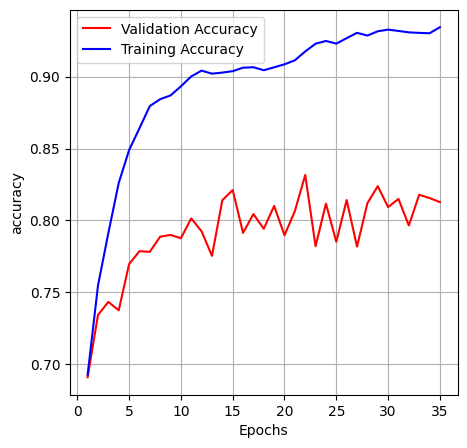


number:  26  feature name:  MotTrqCmd
BattCrnt:1
Epoch 1/35
2856/2856 - 54s - loss: 0.5448 - accuracy: 0.6839 - val_loss: 0.5673 - val_accuracy: 0.7203 - 54s/epoch - 19ms/step
Epoch 2/35
2856/2856 - 48s - loss: 0.4325 - accuracy: 0.7485 - val_loss: 0.5937 - val_accuracy: 0.7098 - 48s/epoch - 17ms/step
Epoch 3/35
2856/2856 - 48s - loss: 0.3809 - accuracy: 0.7874 - val_loss: 0.5939 - val_accuracy: 0.7773 - 48s/epoch - 17ms/step
Epoch 4/35
2856/2856 - 48s - loss: 0.3454 - accuracy: 0.8113 - val_loss: 0.7561 - val_accuracy: 0.7439 - 48s/epoch - 17ms/step
Epoch 5/35
2856/2856 - 48s - loss: 0.2957 - accuracy: 0.8413 - val_loss: 0.7374 - val_accuracy: 0.7704 - 48s/epoch - 17ms/step
Epoch 6/35
2856/2856 - 48s - loss: 0.2478 - accuracy: 0.8699 - val_loss: 0.6780 - val_accuracy: 0.7951 - 48s/epoch - 17ms/step
Epoch 7/35
2856/2856 - 48s - loss: 0.2199 - accuracy: 0.8878 - val_loss: 0.7841 - val_accuracy: 0.8011 - 48s/epoch - 17ms/step
Epoch 8/35
2856/2856 - 48s - loss: 0.2157 - accuracy: 0.8894 

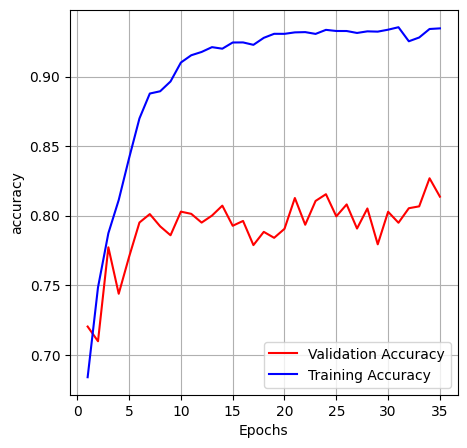


number:  27  feature name:  BattCrnt:1
MotPwrElec:1
Epoch 1/35
2856/2856 - 54s - loss: 0.5439 - accuracy: 0.6852 - val_loss: 0.5564 - val_accuracy: 0.7156 - 54s/epoch - 19ms/step
Epoch 2/35
2856/2856 - 48s - loss: 0.4325 - accuracy: 0.7475 - val_loss: 0.5691 - val_accuracy: 0.7160 - 48s/epoch - 17ms/step
Epoch 3/35
2856/2856 - 48s - loss: 0.3735 - accuracy: 0.7921 - val_loss: 0.6539 - val_accuracy: 0.7555 - 48s/epoch - 17ms/step
Epoch 4/35
2856/2856 - 48s - loss: 0.3160 - accuracy: 0.8321 - val_loss: 0.6772 - val_accuracy: 0.7758 - 48s/epoch - 17ms/step
Epoch 5/35
2856/2856 - 48s - loss: 0.2747 - accuracy: 0.8552 - val_loss: 0.5994 - val_accuracy: 0.7351 - 48s/epoch - 17ms/step
Epoch 6/35
2856/2856 - 48s - loss: 0.2542 - accuracy: 0.8689 - val_loss: 0.6721 - val_accuracy: 0.7760 - 48s/epoch - 17ms/step
Epoch 7/35
2856/2856 - 48s - loss: 0.2304 - accuracy: 0.8826 - val_loss: 0.7765 - val_accuracy: 0.7914 - 48s/epoch - 17ms/step
Epoch 8/35
2856/2856 - 48s - loss: 0.2037 - accuracy: 0.89

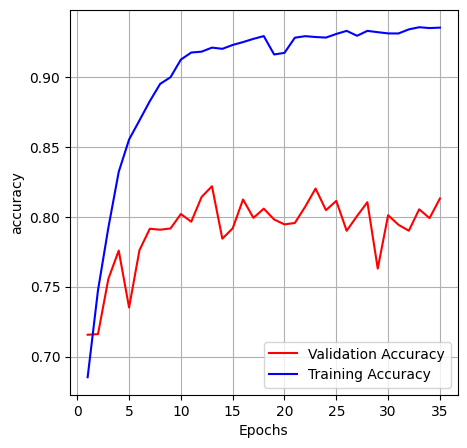


number:  28  feature name:  MotPwrElec:1
MotPwrMech:1
Epoch 1/35
2856/2856 - 54s - loss: 0.5487 - accuracy: 0.6815 - val_loss: 0.5278 - val_accuracy: 0.7237 - 54s/epoch - 19ms/step
Epoch 2/35
2856/2856 - 48s - loss: 0.4263 - accuracy: 0.7520 - val_loss: 0.5517 - val_accuracy: 0.7331 - 48s/epoch - 17ms/step
Epoch 3/35
2856/2856 - 48s - loss: 0.3714 - accuracy: 0.7921 - val_loss: 0.6062 - val_accuracy: 0.7185 - 48s/epoch - 17ms/step
Epoch 4/35
2856/2856 - 48s - loss: 0.3251 - accuracy: 0.8250 - val_loss: 0.6620 - val_accuracy: 0.7404 - 48s/epoch - 17ms/step
Epoch 5/35
2856/2856 - 48s - loss: 0.2732 - accuracy: 0.8557 - val_loss: 0.7020 - val_accuracy: 0.7785 - 48s/epoch - 17ms/step
Epoch 6/35
2856/2856 - 48s - loss: 0.2611 - accuracy: 0.8615 - val_loss: 0.7008 - val_accuracy: 0.7838 - 48s/epoch - 17ms/step
Epoch 7/35
2856/2856 - 48s - loss: 0.2337 - accuracy: 0.8751 - val_loss: 0.7365 - val_accuracy: 0.7769 - 48s/epoch - 17ms/step
Epoch 8/35
2856/2856 - 48s - loss: 0.2138 - accuracy: 0.

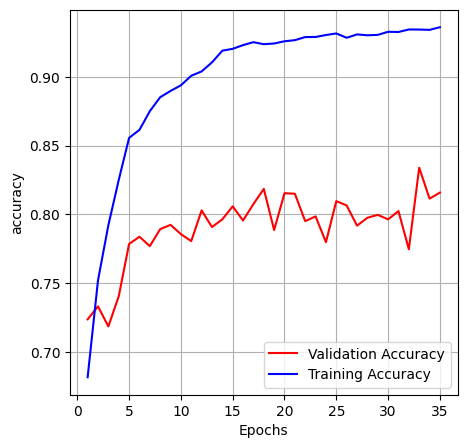


number:  29  feature name:  MotPwrMech:1
IntkVlvLiftCmd
Epoch 1/35
2856/2856 - 56s - loss: 0.5395 - accuracy: 0.6899 - val_loss: 0.5221 - val_accuracy: 0.7211 - 56s/epoch - 20ms/step
Epoch 2/35
2856/2856 - 48s - loss: 0.4303 - accuracy: 0.7485 - val_loss: 0.5365 - val_accuracy: 0.7287 - 48s/epoch - 17ms/step
Epoch 3/35
2856/2856 - 48s - loss: 0.3821 - accuracy: 0.7830 - val_loss: 0.5879 - val_accuracy: 0.7470 - 48s/epoch - 17ms/step
Epoch 4/35
2856/2856 - 48s - loss: 0.3431 - accuracy: 0.8125 - val_loss: 0.5624 - val_accuracy: 0.7493 - 48s/epoch - 17ms/step
Epoch 5/35
2856/2856 - 48s - loss: 0.3034 - accuracy: 0.8362 - val_loss: 0.7746 - val_accuracy: 0.7395 - 48s/epoch - 17ms/step
Epoch 6/35
2856/2856 - 48s - loss: 0.2558 - accuracy: 0.8652 - val_loss: 0.7619 - val_accuracy: 0.7891 - 48s/epoch - 17ms/step
Epoch 7/35
2856/2856 - 48s - loss: 0.2191 - accuracy: 0.8829 - val_loss: 0.7436 - val_accuracy: 0.7763 - 48s/epoch - 17ms/step
Epoch 8/35
2856/2856 - 48s - loss: 0.2115 - accuracy: 

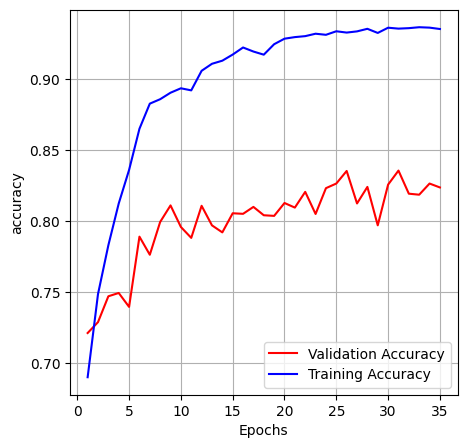


number:  30  feature name:  IntkVlvLiftCmd
FuelMainSoi
Epoch 1/35
2856/2856 - 55s - loss: 0.5341 - accuracy: 0.6920 - val_loss: 0.6006 - val_accuracy: 0.6896 - 55s/epoch - 19ms/step
Epoch 2/35
2856/2856 - 48s - loss: 0.4296 - accuracy: 0.7498 - val_loss: 0.5896 - val_accuracy: 0.7063 - 48s/epoch - 17ms/step
Epoch 3/35
2856/2856 - 48s - loss: 0.3843 - accuracy: 0.7824 - val_loss: 0.5735 - val_accuracy: 0.7472 - 48s/epoch - 17ms/step
Epoch 4/35
2856/2856 - 48s - loss: 0.3379 - accuracy: 0.8155 - val_loss: 0.6184 - val_accuracy: 0.7497 - 48s/epoch - 17ms/step
Epoch 5/35
2856/2856 - 48s - loss: 0.2976 - accuracy: 0.8418 - val_loss: 0.7265 - val_accuracy: 0.7624 - 48s/epoch - 17ms/step
Epoch 6/35
2856/2856 - 48s - loss: 0.2525 - accuracy: 0.8674 - val_loss: 0.6686 - val_accuracy: 0.7838 - 48s/epoch - 17ms/step
Epoch 7/35
2856/2856 - 48s - loss: 0.2367 - accuracy: 0.8779 - val_loss: 0.6762 - val_accuracy: 0.7954 - 48s/epoch - 17ms/step
Epoch 8/35
2856/2856 - 48s - loss: 0.2101 - accuracy: 0

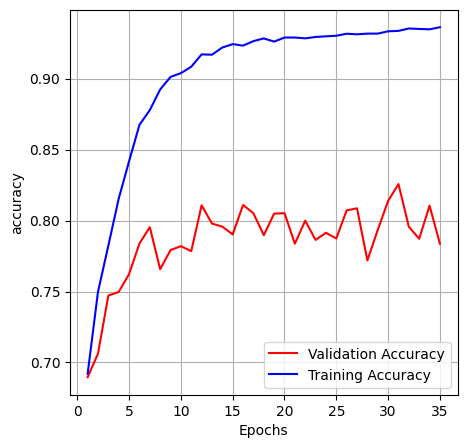


number:  31  feature name:  FuelMainSoi
FuelFlw
Epoch 1/35
2856/2856 - 54s - loss: 0.5399 - accuracy: 0.6888 - val_loss: 0.5649 - val_accuracy: 0.7049 - 54s/epoch - 19ms/step
Epoch 2/35
2856/2856 - 47s - loss: 0.4268 - accuracy: 0.7534 - val_loss: 0.5775 - val_accuracy: 0.7505 - 47s/epoch - 16ms/step
Epoch 3/35
2856/2856 - 47s - loss: 0.3812 - accuracy: 0.7849 - val_loss: 0.6548 - val_accuracy: 0.7394 - 47s/epoch - 16ms/step
Epoch 4/35
2856/2856 - 47s - loss: 0.3429 - accuracy: 0.8119 - val_loss: 0.7141 - val_accuracy: 0.7303 - 47s/epoch - 16ms/step
Epoch 5/35
2856/2856 - 47s - loss: 0.3125 - accuracy: 0.8326 - val_loss: 0.7117 - val_accuracy: 0.7126 - 47s/epoch - 16ms/step
Epoch 6/35
2856/2856 - 47s - loss: 0.2740 - accuracy: 0.8566 - val_loss: 0.7612 - val_accuracy: 0.7612 - 47s/epoch - 16ms/step
Epoch 7/35
2856/2856 - 47s - loss: 0.2446 - accuracy: 0.8711 - val_loss: 0.7481 - val_accuracy: 0.7816 - 47s/epoch - 16ms/step
Epoch 8/35
2856/2856 - 47s - loss: 0.2567 - accuracy: 0.8645 -

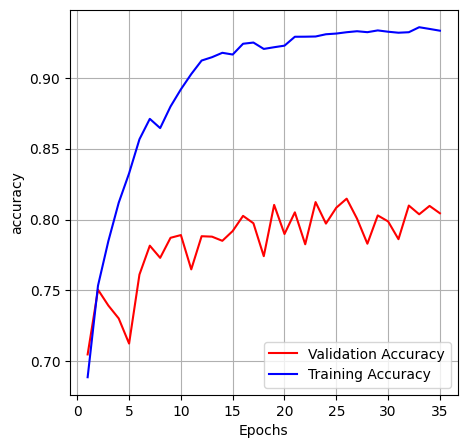


number:  32  feature name:  FuelFlw


In [23]:
for masked_feature_name in feature_list:
    counter += 1
    print(masked_feature_name)
    # generate the masked matrix
    dimension, x_train, x_test, x_cv = x_generator(masked = True, feature_name = masked_feature_name)

    # training
    masked_model = train_model(x_train, y_train, x_cv, y_cv, dimension['train_col'], masked_feature_name)

    # load the history of the current model
    with open('/content/drive/MyDrive/models/' + masked_feature_name + '/history.pickle', "rb") as hisotry_file:
        history = pickle.load(hisotry_file)

    # saving the visulization
    visulize_model(history, masked_feature_name)

#     # log the test set performance
#     score, acc = complete_model.evaluate(x_test, y_test, verbose=0)
#     test_results[masked_feature_name] = (acc, score)

#     # log the peak validation set performance
#     val_peak = max(history['val_accuracy'])
#     val_results[masked_feature_name] = val_peak
#     val_diff[masked_feature_name] = complete_peak - val_peak

    # log that this feature has been masked once
    already_masked.append(masked_feature_name)

    print()
    print('number: ', counter, ' feature name: ', masked_feature_name)

# Visualization

#### Benchmark

In [24]:
complete_val = 0.913281261920929
complete_test = 0.896640419960022

#### Utility function

In [25]:
def plot_dict(dictionary):
    x, y = [], []
    for key, value in dictionary.items():
        x.append(key)
        y.append(value)
    return x, y

#### Log

In [26]:
test_results = dict() # keeps track of test set performance
test_diff = dict()

val_results = dict() # keeps the highest validation accuracy of a model
val_diff = dict() # keeps the difference in terms of accuracy when compared to the complete model

In [27]:
counter = 1
for name in feature_list:
    with open('/content/drive/MyDrive/models/' + name + '/history.pickle', "rb") as hisotry_file:
        history = pickle.load(hisotry_file)
    val_acc = max(history['val_accuracy'])
    val_results[name] = val_acc
    val_diff[name] = complete_val - val_acc

    model = load_model('/content/drive/MyDrive/models/'+name)
    dimension, x_train, x_test, x_cv = x_generator(masked = True, feature_name = name)
    score, acc = model.evaluate(x_test, y_test, verbose=1)
    print(str(counter)+'/52')
    test_results[name] = acc
    test_diff[name] = complete_test - acc
    counter += 1

7615/7615 [==============================] - 86s 11ms/step - loss: 0.7528 - accuracy: 0.8306
1/52
7615/7615 [==============================] - 85s 11ms/step - loss: 1.0250 - accuracy: 0.8167
2/52
7615/7615 [==============================] - 88s 11ms/step - loss: 0.7352 - accuracy: 0.8361
3/52
7615/7615 [==============================] - 84s 11ms/step - loss: 1.0676 - accuracy: 0.8242
4/52
7615/7615 [==============================] - 85s 11ms/step - loss: 0.8561 - accuracy: 0.8128
5/52
7615/7615 [==============================] - 86s 11ms/step - loss: 0.7821 - accuracy: 0.8307
6/52
7615/7615 [==============================] - 85s 11ms/step - loss: 0.7240 - accuracy: 0.8452
7/52
7615/7615 [==============================] - 84s 11ms/step - loss: 0.8367 - accuracy: 0.8372
8/52
7615/7615 [==============================] - 84s 11ms/step - loss: 0.7896 - accuracy: 0.8149
9/52
7615/7615 [==============================] - 86s 11ms/step - loss: 0.7517 - accuracy: 0.8470
10/52
7615/7615 [========

#### Plotting

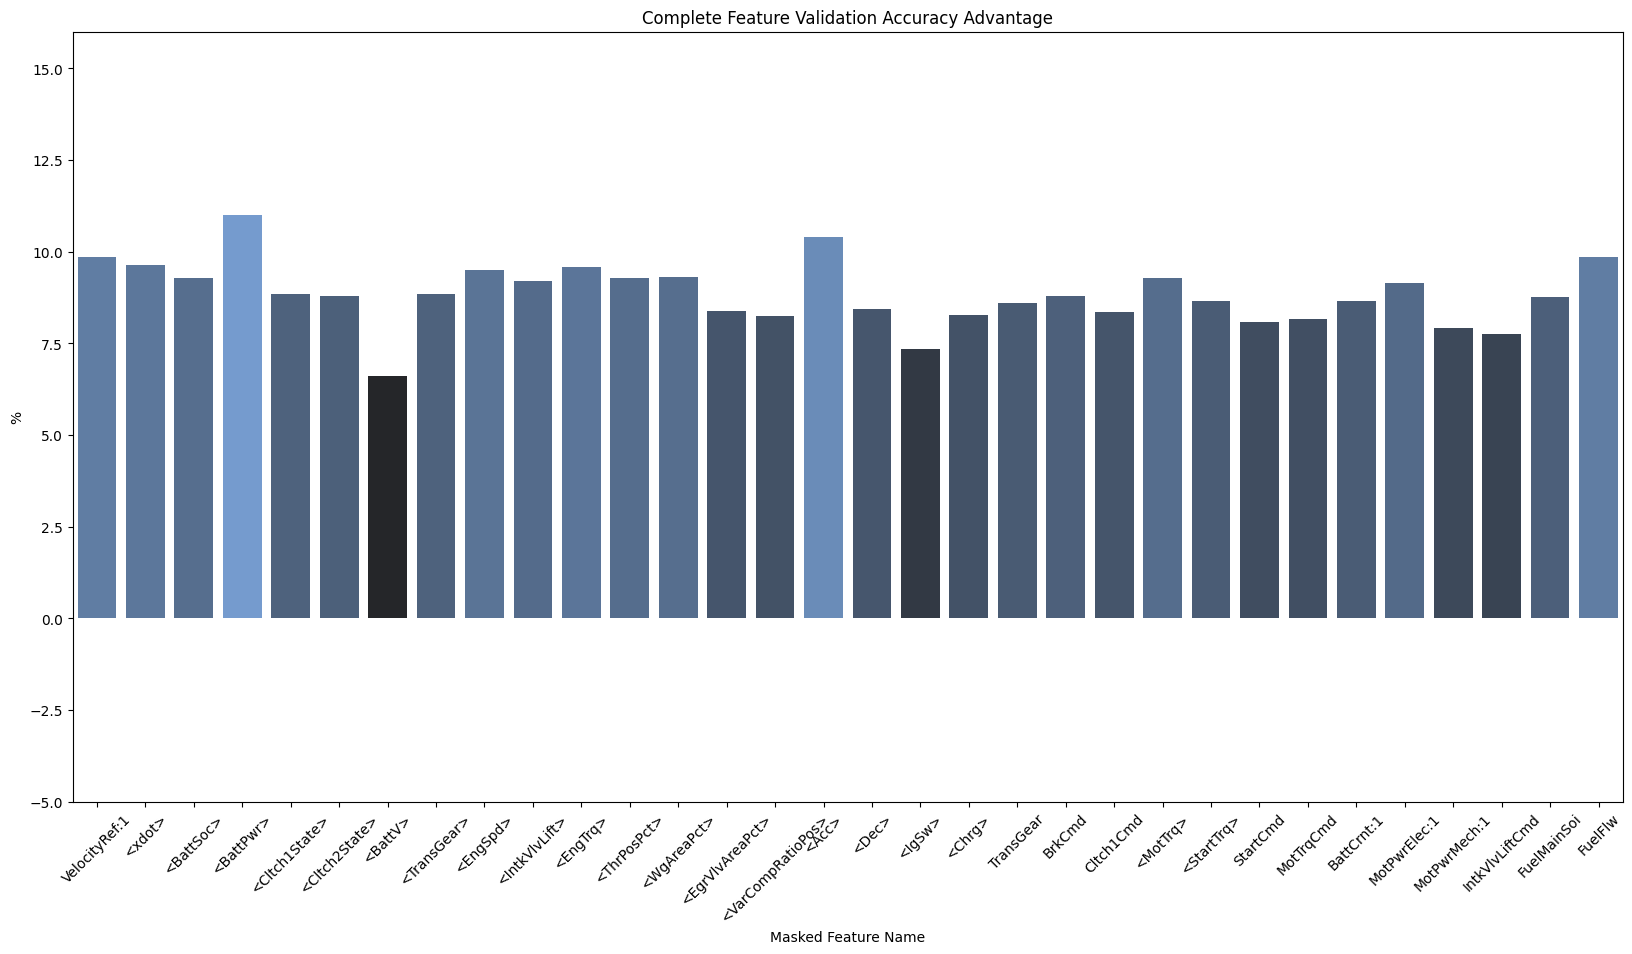

In [28]:
x_1, y_1 = plot_dict(val_diff)
y_1_100 = [z * 100 for z in y_1]
plt.figure(figsize=(20,10))
sns.barplot(x=x_1,y= y_1_100, palette = mpl.cm.ScalarMappable(cmap=sns.dark_palette("#69d", reverse=False, as_cmap=True)).to_rgba(y_1_100))
plt.xticks(rotation=45);
plt.ylim((-5.0, 16.0))
plt.title('Complete Feature Validation Accuracy Advantage')
plt.ylabel('%')
plt.xlabel('Masked Feature Name');

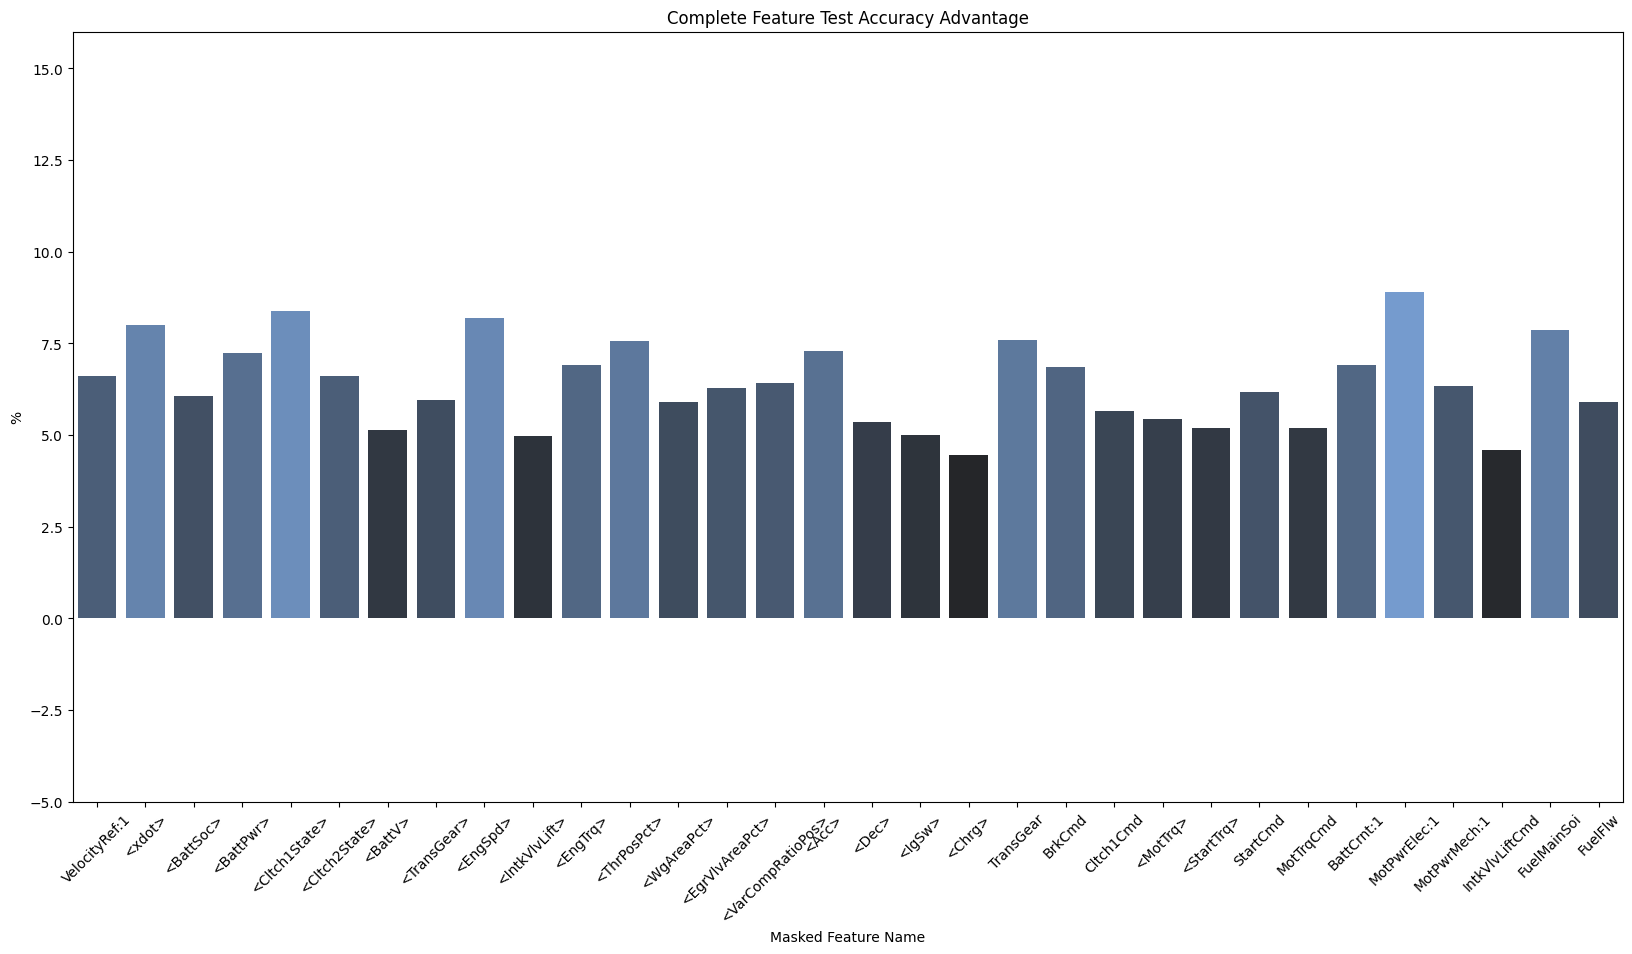

In [30]:
x_2, y_2 = plot_dict(test_diff)
y_2_100 = [z * 100 for z in y_2]
plt.figure(figsize=(20,10))
sns.barplot(x=x_2,y= y_2_100, palette = mpl.cm.ScalarMappable(cmap=sns.dark_palette("#69d", reverse=False, as_cmap=True)).to_rgba(y_2_100))
plt.xticks(rotation=45);
plt.ylim((-5.0, 16.0))
plt.title('Complete Feature Test Accuracy Advantage')
plt.ylabel('%')
plt.xlabel('Masked Feature Name');

# Prepare for EVSI

In [31]:
temp_list = sorted(val_diff.items(), key=lambda x: x[1], reverse= True)[0:10]

top_10 = list()
for the_tuple in temp_list:
    top_10.append(the_tuple[0])
top_10

random.shuffle(top_10)

top_10

['<EngSpd>',
 'FuelFlw',
 '<EngTrq>',
 '<ThrPosPct>',
 '<Acc>',
 'VelocityRef:1',
 '<BattSoc>',
 '<xdot>',
 '<WgAreaPct>',
 '<BattPwr>']